In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.io import loadmat
from itertools import combinations
from scipy.special import erfcinv


In [2]:
data = loadmat('SpanishDomainF.mat')
SpanishDomainF = data['SpanishDomainF']

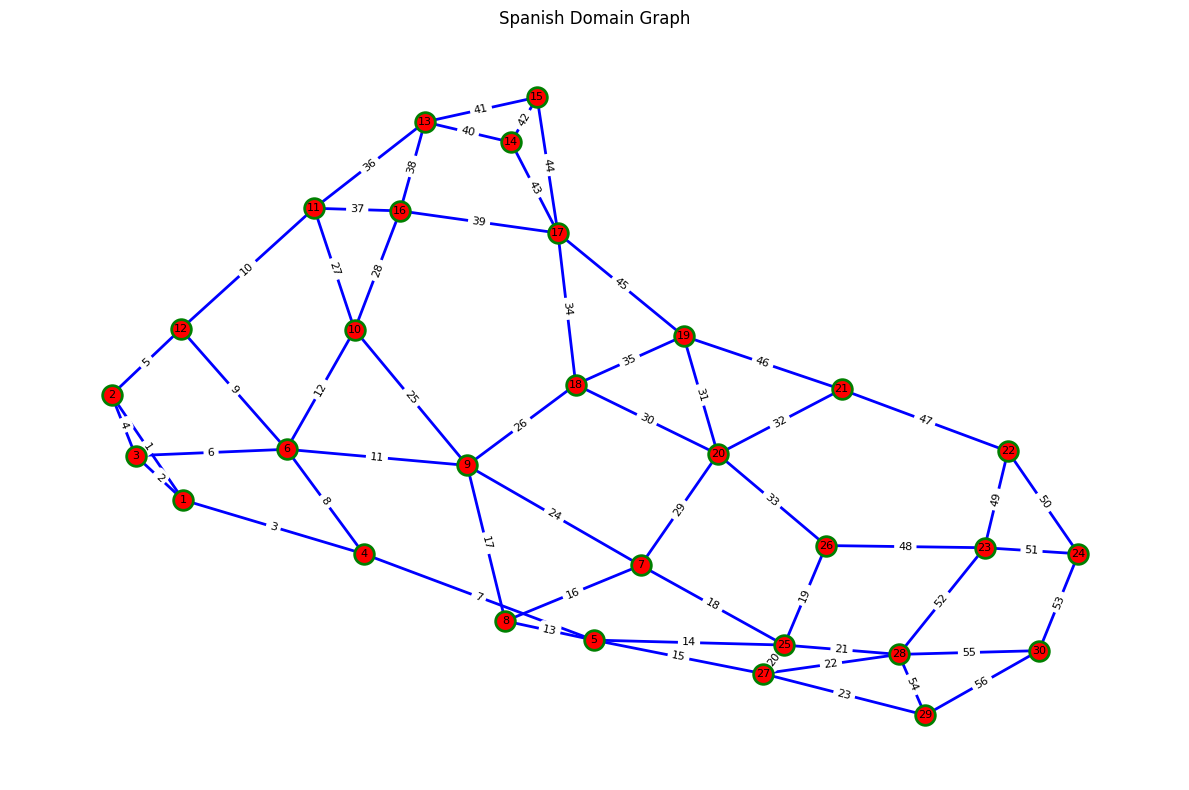

In [3]:
s = SpanishDomainF[:, 0] #first column
t = SpanishDomainF[:, 1]  #second column
weights = SpanishDomainF[:, 2]  #third column
names = [str(i) for i in range(1, 31)]

G = nx.Graph()
for i in range(len(s)):
    source_node = names[int(s[i])-1]
    target_node = names[int(t[i]-1)]
    weight = weights[i]
    G.add_edge(source_node, target_node, weight = weight)
plt.figure(11, figsize = (12,8))
pos = nx.spring_layout(G, seed = 42)
nodes = nx.draw_networkx_nodes(G, pos, 
                               node_color='red',
                               node_size=200,
                               linewidths=2,
                               edgecolors='green')
edges = nx.draw_networkx_edges(G, pos, 
                               edge_color='blue',
                               width=2,
                               style='solid')
nx.draw_networkx_labels(G, pos,
                        font_size=8,
                        font_color='black')
edge_lables = {}
for i, (u,v) in enumerate(G.edges()):
    edge_lables[(u,v)] = i + 1 #edge 1, 2, 3, ...
nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=edge_lables,
                             font_size=8)

plt.title('Spanish Domain Graph')
plt.axis('off')  # Turn off the axis
plt.tight_layout()
plt.show()

In [ ]:
#Set the Initial Parameters for RMWA 
k_paths = 1 # K-ShortestPath
num_MC = 1000 # Monte-Carlo repetition
num_request = [500] 

weights_array = np.array(weights) * 1000 
Lspan = 70000
weights_Nspan = np.ceil(weights_array / Lspan)
weights_Lspan = weights_array / weights_Nspan
added_dist_links = weights_Nspan * Lspan - weights_array

G = nx.Graph()
for i in range(len(s)):
    G.add_edge(s[i], t[i], weight= weights_array[i], Nspan=weights_Nspan[i])

num_link = G.number_of_edges()  #number of links in the graph G
nn = G.number_of_nodes()   #number of nodes in the graph G

edges = list(G.edges(data=True))
s = [edge[0] for edge in edges] #stores the first column
t = [edge[1] for edge in edges] #second coulumn 
weights = [edge[2]['weight'] for edge in edges] #third --> weights

netCostMatrix = nx.to_numpy_array(G, weight='weight', nonedge=0, dtype=np.float64)

topo_matrix = netCostMatrix + netCostMatrix.T
netCostMatrix = netCostMatrix + netCostMatrix.T

for request_counter in range(nn): 
    for q in range(nn): 
        if netCostMatrix[request_counter, q] == 0:
            netCostMatrix[request_counter, q] = np.inf

uniq_nodes = names
num_node = list(range(1, len(uniq_nodes) + 1))
connect_counter = 0
lp_counter = int((len(uniq_nodes) * (len(uniq_nodes) - 1)) / 2)
LP_matx = np.zeros(((len(uniq_nodes)), lp_counter))

link_list_allpath = []  
totalCosts_allpath = []    
totalCosts_allpath_Nspan = []  

for source_counter in range(len(uniq_nodes)): 
    source_selected = num_node[source_counter]
    for source_counter2 in range(source_counter + 1, len(uniq_nodes)):
        destination_selected = num_node[source_counter2]

        #Get k shortest paths using netx
        shortestPaths = []
        totalCosts = []

        path_generator = nx.shortest_simple_paths(G, source_selected, destination_selected,
                                                  weight='weight')
        
        for i, path in enumerate(path_generator): 
            if i >= k_paths: 
                break
            shortestPaths.append(path)
            #calculate total cost for this path
            path_cost = 0 
            for u, v in zip(path[:-1], path[1:]):
                path_cost += G[u][v]['weight']
            totalCosts.append(path_cost)
            
            LP_matx[source_counter, source_counter2] = min(totalCosts) if totalCosts \
                else float('inf')

            selected_link = []
            LP_matx_Nspan = []
            
            for KSP_counter in range(len(totalCosts)):
                nodes_ShPath = shortestPaths[KSP_counter]
                num_nodes_ShPath = len(nodes_ShPath)
                source_link = nodes_ShPath[:-1] 
                destination_link = nodes_ShPath[1:]
                idx_link = []
                
                for src, dest in zip(source_link, destination_link):            
                    idx_link.append((src, dest))
                
                selected_link.append(idx_link)
                
                Nspan_path_link = []
                for src, dest in idx_link:
                    Nspan_path_link.append(G[src][dest]['Nspan'])
                LP_matx_Nspan.append(sum(Nspan_path_link))
            
            connect_counter += 1
            link_list_allpath.append(selected_link)
            totalCosts_allpath.append(totalCosts)
            totalCosts_allpath_Nspan.append(LP_matx_Nspan)
degree_node_all_topo = []

for request_counter in range(nn):
    degree_node_all_topo.append(np.count_nonzero(topo_matrix[:, request_counter]))
degree_node_all_topo = np.array(degree_node_all_topo)

max_degree_node = np.max(degree_node_all_topo)
min_degree_node = np.min(degree_node_all_topo)
ave_degree_node = np.mean(degree_node_all_topo)

pop_list_nodes = np.random.rand(nn) #random population
LP_matx = LP_matx / 1000.0
sum_multi_sd_degree = 0

for request_counter in range(nn - 1):
    for j in range(nn):
        if LP_matx[request_counter, j] != 0:
            sum_multi_sd_degree += (degree_node_all_topo[request_counter]) * degree_node_all_topo[j]

sd_counter = 0 
all_sd_pair = []
sd_pair_pdf = np.zeros((nn , nn))

for request_counter in range(nn - 1):
    for j in range(nn):
        if LP_matx[request_counter, j] != 0:
            sd_counter += 1

            prob = (degree_node_all_topo[request_counter] * degree_node_all_topo[j]) / sum_multi_sd_degree
            all_sd_pair.append([request_counter, j, prob])
            sd_pair_pdf[request_counter, j] = prob
            sd_pair_pdf[j, request_counter] = prob

all_sd_pair = np.array(all_sd_pair)

non_uniform_sd_selection = all_sd_pair[:, 2]

bit_rate_MFC = np.ceil(64 * (1 + 0.0742 * 1) * 
                       np.array([2, 4, 6, 8, 10, 12]) * 0.725) *1e9

alpha_db = 0.22; #attenuation dB/km

alpha_norm = alpha_db / (10 * np.log10(np.e) * 1000) 

beta_2 = -21.28e-27 #Group velocity dispersion (s^2 / m)

gamma = 1.27e-3      #Nonlinear parameter 1/(W.m)

L_eff_a = 1/(1 * alpha_norm) #L_eff_a is defined as 1/alpha

target_ber = 1e-3 %3.8e-3

# M=2; PM-BPSK 
target_SNR_dB_2 = 10 * np.log10(1 * (erfcinv(2 * target_ber))**2)
# M=4; PM_QPSK 
target_SNR_dB_4 = 10 * np.log10(2 * (erfcinv(2 * target_ber))**2)
# M=8; PM_8QAM
target_SNR_dB_8 = 10 * np.log10((14/3) * (erfcinv(1.5 * target_ber))**2)
# M=16; PM_16QAM
target_SNR_dB_16 = 10 * np.log10((10) * (erfcinv((8/3) * target_ber))**2)
M=32; #PM_32QAM
target_SNR_dB_32 = 10 * np.log10(2 * (erfcinv(np.log2(M) * target_ber/2/(1-1/np.sqrt(M))))**(2 * (M-1)/3))
M=64; #PM_64QAM
target_SNR_dB_64 = 10 * np.log10(2 * (erfcinv(np.log2(M) * target_ber/2/(1-1/np.sqrt(M))))**(2 * (M-1)/3))

target_SNR_dB = np.array ([target_SNR_dB_2, target_SNR_dB_4, target_SNR_dB_8,
                           target_SNR_dB_16, target_SNR_dB_32, target_SNR_dB_64])


In [ ]:
# ASE Parameters
F_C = 10**0.43  #Noise Figure ~2.7 (6 dB)
h_plank = 6.62e-34  #Planck's constant (J.s)

#RMSA 

# Tx_Rx Configuration 
n_Rs = 1  # 1 2 3 4 for 14 32 64 96 GBd
rof = 0.1  #roll-off
Rs = 64e9 
B_ch = Rs * (1 + rof)   #Channels' Bandwidth (GHz)
Freq_Granularity_mat = np.ceil(Rs / 12.5e9) * 12.5 #Ghz

def create_spectrum(Freq_Granularity_mat, Rs_mat): 
    mat_f_c = []
    Nch_mat = []

    speed_of_light = 2.99792458e8

    for Rs_count in range(len(Rs_mat)):
        Freq_Granularity = Freq_Granularity_mat[Rs_count]

        freq_step = Freq_Granularity * 1e-3 * 1e12 #Calculate freq. step

        f_c_start = speed_of_light / (1530.0555e-9) # ~196.05 THz
        f_c_final = speed_of_light / (1565e-9)      # ~191.56 THz

        f_ref = 193.1e12 #Reference Frequency 

        num_below = int(np.ceil((f_ref - f_c_final) / freq_step)) 
        num_above = int(np.ceil((f_c_start - f_ref) / freq_step))

        #Generate frequencies BELOW reference
        mat_f_c_1 = [f_ref] # mat_f_c_1[1] = f_ref
        for i in range(1, num_below + 1):
            freq = f_ref - (i * freq_step)
            if freq >= f_c_final: 
                mat_f_c_1.append(freq)
        
        #Generate frequencies ABOVE reference
        mat_f_c_r = []
        for i in range(1, num_above + 2):
            if i == 1: 
                freq = f_ref + freq_step #first above ref
            else: 
                freq = f_ref + (i * freq_step)
            if freq <= f_c_start: 
                mat_f_c_r.append(freq)

        frequencies = sorted(mat_f_c_r + mat_f_c_1[1:], reverse=True)

        mat_f_c.append(frequencies)
        Nch_mat.append(len(frequencies))
    return mat_f_c, Nch_mat   

f_c_axis_list, num_Ch_mat = create_spectrum(Freq_Granularity_mat, Rs)
f_c_axis = f_c_axis_list[n_Rs - 1]
num_FS = len(f_c_axis)

#Power parameters
p_tx_opt = -0.4 #in dBm
Ptx = 10 ** ((p_tx_opt - 30) / 10) #Convert dBm to Watts

p_cut = Ptx
p_k = Ptx

phi_MFL = -1 * np.array([1, 1, 2/3, 17/25, 69/100, 13/21])

alpha_norm_bar = alpha_norm
Att = alpha_norm + alpha_norm_bar

Lspan_actual = Lspan

P_tot = 1
epsilon = 0
beta_3 = 0
Cr = 0

fc = np.median(f_c_axis)

#Modulation Reach Distances
MRD = np.array([119, 60, 24, 12, 6, 3]) #format 6: 119 distance units -> format 1: 3 distance units

#Spectrum Assignment
allchannel_net = num_FS * len(G.edges()) #freq_slots * network lines
Links_loading_state_MC = []

num_request_batches = len(num_request)

mean_GSNR_LP_MC = np.zeros(num_request_batches)
mean_num_block_percent_MC = np.zeros(num_request_batches)
mean_num_established_LP = np.zeros(num_request_batches)
mean_established_capacity = np.zeros(num_request_batches)
Busy_Channel_network_mont_carlo = np.zeros(num_request_batches)
specteral_efficiency_network_mont_carlo = np.zeros(num_request_batches)
mean_Links_loading_state_MC = np.zeros((num_request_batches, G.number_of_edges()))

mean_Links_loading_state_MC = np.zeros((num_request_batches, num_link))

mean_MFC_1_MC = np.zeros(num_request_batches)
mean_MFC_2_MC = np.zeros(num_request_batches)
mean_MFC_3_MC = np.zeros(num_request_batches)
mean_MFC_4_MC = np.zeros(num_request_batches)
mean_MFC_5_MC = np.zeros(num_request_batches)
mean_MFC_6_MC = np.zeros(num_request_batches)

for request_counter in range(len(num_request)):
    
    current_batch_size = num_request[request_counter]
    GSNR_LP_MC = np.zeros(num_MC)
    num_block_MC_percent = np.zeros(num_MC)
    num_established_LP = np.zeros(num_MC)
    established_capacity = np.zeros(num_MC)
    Busy_Channel_network = np.zeros(num_MC)
    specteral_efficiency_network = np.zeros(num_MC)

    Links_loading_state_MC_local = np.zeros((num_MC, num_link))

    MFC_1_MC_local = np.zeros(num_MC)
    MFC_2_MC_local = np.zeros(num_MC)
    MFC_3_MC_local = np.zeros(num_MC)
    MFC_4_MC_local = np.zeros(num_MC)
    MFC_5_MC_local = np.zeros(num_MC)
    MFC_6_MC_local = np.zeros(num_MC)

    mean_GSNR_margin_MC_all_MFC = np.zeros(num_MC)
    max_GSNR_margin_MC_all_MFC = np.zeros(num_MC)
    min_GSNR_margin_MC_all_MFC = np.zeros(num_MC)

    mean_Margin_MFC_MC_local = np.zeros((num_MC, 6))  # Mean margins per MFC
    max_Margin_MFC_MC_local = np.zeros((num_MC, 6))   # Max margins per MFC
    min_Margin_MFC_MC_local = np.zeros((num_MC, 6))   # Min margins per MFC

    for mont_carlo in range(num_MC):

        # Print progress
        if mont_carlo % 100 == 0:
            print(f"Request batch {request_counter + 1}, Monte Carlo {mont_carlo + 1}/{num_MC}")

        sd_selected_nonunibaiased = np.zeros(num_request[request_counter], dtype=int)
        
        for num_req in range(num_request[request_counter]):
            num_sd_pairs = len(LP_matx) // 2 
            values = list(range(1, num_sd_pairs + 1))
            probabilities = non_uniform_sd_selection 
            if np.sum(probabilities) > 0:
                probabilities = probabilities / np.sum(probabilities)
            else: 
                probabilities = np.ones(len(values)) / len(values)
            sd_selected_nonunibaiased[num_req] = np.random.choice(values, p=probabilities)

        Link_state = np.zeros((num_FS, G.number_of_edges()), dtype=int)

        MFL_state = np.zeros((num_FS, G.number_of_edges()), dtype=int)

        num_block = 0
        MFC_0 = 0; MFC_1 = 0; MFC_2 = 0; MFC_3 = 0; MFC_4 = 0; MFC_5 = 0; MFC_6 = 0

        GSNR_LP = np.zeros(num_request[request_counter])  
        GSNR_margin = np.zeros(num_request[request_counter]) 

        MFC_traffic_matrix = {}

        for num_req in range(num_request[request_counter]): 
            idx = sd_selected_nonunibaiased[num_req] - 1 
            LP_dist_list = totalCosts_allpath_Nspan[idx]
            link_list = link_list_allpath[idx]
            path_counter = 0
            flag_establish = False

            if max(LP_dist_list) <= max(MRD):
                while path_counter < len(LP_dist_list):
                    LP_dist = LP_dist_list[path_counter]
                    selected_link = link_list[path_counter]
                    PST = np.zeros(num_FS, dtype=int)

                    for FS_c in range(num_FS):
                        vector_state_FS = []
                        for count_link in range(len(selected_link)): 
                            link_idx = selected_link[count_link]
                            vector_state_FS.append(Link_state[FS_c, link_idx])
                        if any(state >= 1 for state in vector_state_FS):
                            PST[FS_c] = 1
                        elif all(state == 0 for state in vector_state_FS): 
                            PST[FS_c] = 0

                    idle_chs = np.where(PST == 0)[0]

                    if len(idle_chs) > 0: 

                        FF_idle_chs = idle_chs[0]

                        #Modulation Format Assignment
                        
                        if LP_dist <= MRD[5]:
                            MFC_value = 6 
                            MFC_6 = MFC_6 + 1
                        elif MRD[5] < LP_dist and LP_dist <= MRD[4]:
                            MFC_value = 5
                            MFC_5 = MFC_5 + 1
                        elif MRD[4] < LP_dist and LP_dist <= MRD[3]:
                            MFC_value = 4
                            MFC_4 = MFC_4 + 1
                        elif MRD[3] < LP_dist and LP_dist <= MRD[2]:
                            MFC_value = 3
                            MFC_3 = MFC_3 + 1
                        elif MRD[2] < LP_dist and LP_dist <= MRD[1]:
                            MFC_value = 2
                            MFC_2 = MFC_2 + 1
                        elif MRD[1] < LP_dist and LP_dist <= MRD[0]:
                            MFC_value = 1
                            MFC_1 = MFC_1 + 1
                        else: 
                            MFC_value = 0 
                        MFC_traffic_matrix[num_req] = MFC_value
                        for link_count in range(len(selected_link)):
                            Link_state[FF_idle_chs, selected_link[link_count]] = num_req + 1
                            MFL_state[FF_idle_chs, selected_link[link_count]] = MFC_value
                        
                        flag_establish = True


                        #GSNR Estimation
                        flag_Qot = 0
                        P_ASE_link = 0
                        eta_total = 0
                        f_cut = f_c_axis(FF_idle_chs)
                        phi_cut = 1.5 * ((np.pi) ** 2) * (beta_2 + 2 * beta_3 * (f_cut-fc))
                        T_cut = (Att - P_tot * Cr * (f_cut - 1 * fc)) ** 2
                        T_tilda = -1 * P_tot * Cr * (f_cut - 1 * fc) / alpha_norm_bar

                        for link_count2 in range(len(selected_link)):
                            link_idx = selected_link[link_count2]
                            Lspan = weights_Lspan[link_idx]

                            #calculate ASE gain
                            G_ASE = (1 + T_tilda) * np.exp(-1 * alpha_norm * Lspan) 
                            - T_tilda * np.exp(-1 * (alpha_norm + alpha_norm_bar) * Lspan) 
                            
                            n_s = weights_Nspan[link_idx]
                            if n_s == 1: 
                                n_bar = 0
                            else: 
                                n_bar = n_s
                            
                            #Get Modulation Format and Link State for this link
                            MFL_UT = MFL_state[:, link_idx]
                            Link_UT = Link_state[:, link_idx]
                            Link_UT_nnz = np.where(Link_UT > 0)[0]
                            MFL_UT_nnz = MFL_UT[Link_UT_nnz]
                            
                            if FF_idle_chs <= num_FS: 
                                P_ASE_link = P_ASE_link + n_s * B_ch * h_plank * f_cut * (1/G_ASE - 1) * F_C
                            else: 
                                F_L = F_C 
                                P_ASE_link = P_ASE_link + n_s * B_ch * h_plank * f_cut * (1/G_ASE - 1) * F_L
                            for Ch_count in range(num_FS): 
                                MFL = MFL_UT[Ch_count]
                                f_k = f_c_axis[Ch_count]
                                
                                if f_k == f_cut: 
                                    eta_SCI = (4/9) * (gamma / B_ch)**2 * ((np.pi * n_s**(1+epsilon))/(phi_cut * alpha_norm_bar * (2 * alpha_norm + alpha_norm_bar)))\
                                        *((T_cut - alpha_norm**2) / alpha_norm) * np.asinh((phi_cut * B_ch**2)/(np.pi * alpha_norm))+\
                                        (((Att**2 - T_cut) / Att) * np.asinh((phi_cut * B_ch**2) / (np.pi * Att)))
                                    eta_total = eta_total + eta_SCI
                                
                                else: 
                                    delta_f = f_k - f_cut 
                                    
                                    phi = -4 * np.pi**2 * (beta_2 + np.pi * beta_3 * (f_cut + f_k - 2 * fc)) * Lspan
                                    
                                    T_k = (Att - P_tot * Cr * (f_k - 1 * fc))**2
                                    
                                    phi_cut_k = -2 * np.pi**2 * delta_f * (beta_2 + np.pi * beta_3 * (f_cut + f_k-2 * fc))
                                    
                                    part_1 = ((T_k - alpha_norm**2) / alpha_norm) * np.atan((phi_cut_k * B_ch) / (alpha_norm))+\
                                        (((Att**2 - T_k) / Att) * np.atan((phi_cut_k * B_ch) / (Att)))
                                    
                                    if MFL != 0:
                                        eta_XCI = (32 / 27) * (p_k / p_cut)**2 * (gamma**2 / B_ch) * (((n_s + (5 / 6) * phi_MFL(MFL)) / (phi_cut_k * alpha_norm_bar *\
                                            (2 * alpha_norm + alpha_norm_bar))) * part_1)
                                        
                                        eta_XCI_MFL = (32 / 27) * (p_k / p_cut)**2 * (gamma**2 / B_ch) * (5 / 3) * (((phi_MFL(MFL) * n_bar * np.pi * T_k)\
                                                    / ((np.abs(phi) * B_ch**2 * alpha_norm**2 * Att**2))) * ((2 * np.abs(delta_f) - B_ch)\
                                                    * np.log((2 * np.abs(delta_f) - B_ch) / (2 * np.abs(delta_f) + B_ch)) + 2 * B_ch))
                                    else: 
                                        eta_XCI = (32 / 27) * (p_k / p_cut)**2 * (gamma**2 / B_ch) * (((n_s + (5 / 6) * phi_MFL(1))\
                                            /(phi_cut_k * alpha_norm_bar * (2 * alpha_norm + alpha_norm_bar))) * part_1)
                                        
                                        eta_XCI_MFL = (32 / 27) * (p_k / p_cut)**2 * (gamma**2 / B_ch) * (5 / 3) * (((phi_MFL(1) * n_bar * np.pi * T_k)\
                                                    / ((np.abs(phi) * B_ch**2 * alpha_norm**2 * Att**2))) * ((2 * np.abs(delta_f) - B_ch)\
                                                    * np.log((2 * np.abs(delta_f) - B_ch) /(2 * np.abs(delta_f) + B_ch)) + 2 * B_ch))
                                    eta_total = eta_total + eta_XCI + eta_XCI_MFL

                        #Calculate NLI power and GSNR 
                        P_NLI_link = (Ptx)**3 * eta_total

                        GSNR_value =  10 * np.log10((p_cut - 1 * P_NLI_link) / (p_cut * 10**(-3.6) * 1 + P_ASE_link + P_NLI_link)) - 2*1

                        GSNR_LP[num_req] = GSNR_value
                        
                        if GSNR_value >= target_SNR_dB[MFC_value - 1]:
                            flag_Qot = 1
                        else: 
                            print("flag_QoT_error")
                            raise ValueError("QoT error - GSNR below target")
                        GSNR_margin[num_req] = GSNR_value - target_SNR_dB[MFC_value -1]
                        
                        break
                    path_counter = path_counter + 1
            
            if not flag_establish: 
                num_block = num_block + 1
    #Reports: Network Request Blocking Probability, GSNR, Margin (all, MFCs), 
    # MFCs, Network Capacity, Links Loading states 
        GSNR_LP_nonzero = GSNR_LP[GSNR_LP != 0]
        if len(GSNR_LP_nonzero) > 0:
            GSNR_LP_MC[mont_carlo] = np.mean(GSNR_LP_nonzero)
        
        num_block_MC_percent[mont_carlo] = 100 * num_block / current_batch_size

        num_established_LP[mont_carlo] = current_batch_size - num_block

        mfc_values = list(MFC_traffic_matrix.values())
        established_capacity[mont_carlo] = sum(mfc_values) / 10 #in Tbps

        Busy_Channel_network[mont_carlo] = 100 * np.count_nonzero(Link_state) / allchannel_net

        num_active_connections = len([x for x in MFC_traffic_matrix.values() if x !=0])
        
        if num_active_connections > 0: 
            specteral_efficiency_network[mont_carlo] = (established_capacity[mont_carlo]\
                                                       * 1e12) / (num_active_connections * B_ch)
        
        Links_loading_state = np.zeros(num_link)
        for link_counter in range(num_link): 
            Links_loading_state[link_counter] = 100 * np.count_nonzero(Link_state[link_counter]) / num_FS

        Links_loading_state_MC_local[mont_carlo, :] = Links_loading_state 

        if num_established_LP[mont_carlo] > 0:
            MFC_1_MC_local[mont_carlo] = MFC_1 / num_established_LP[mont_carlo] * 100
            MFC_2_MC_local[mont_carlo] = MFC_2 / num_established_LP[mont_carlo] * 100
            MFC_3_MC_local[mont_carlo] = MFC_3 / num_established_LP[mont_carlo] * 100
            MFC_4_MC_local[mont_carlo] = MFC_4 / num_established_LP[mont_carlo] * 100
            MFC_5_MC_local[mont_carlo] = MFC_5 / num_established_LP[mont_carlo] * 100
            MFC_6_MC_local[mont_carlo] = MFC_6 / num_established_LP[mont_carlo] * 100
        